## Tratamientos de Datos

In [15]:
# Importando librerías 
import pandas as pd
import missingno as msno
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import xlim
from statistics import mode

## Lectura de DataFrame 

In [16]:
data = pd.read_csv(r'propiedades.csv', sep = ',', index_col = 0)
print(f'El dataframe de properati está compuesto por {data.shape[1]} columnas y {data.shape[0]} filas') 
data.sample(3)

El dataframe de properati está compuesto por 15 columnas y 107980 filas


,property_type,state_name,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,price_usd_per_m2,apartment,house,store,amb_2.0,amb_3.0,amb_4.0,amb_5.0,amb_Mayor a 5,amb_No Informado
111129,apartment,Capital Federal,460000.0,152.000000,131.0,3026.315789,1,0,0,0,0,0,1,0,0
51327,house,Bs.As. G.B.A. Zona Sur,NaN,900.000000,120.0,NaN,0,1,0,0,0,0,0,0,1
92293,PH,Corrientes,120000.0,142.332926,81.0,NaN,0,0,0,0,0,0,0,0,1


## 1. Descripción breve del DataFrame.


El DataFrame en estudio cuenta con 15 columnas y un total de 107980 filas (incluyendo valores nulos) por columna. 

MENCIONAR DIRECTAMENTE CARACTERÍSTICAS DE LAS FEATURES

price_aprox_usd = Bo + B1*surface_total_in_m2 + B2surface_covered_in_m2 + ...

In [17]:
# Resumen de nombre y tipo de dato por columna

print('\n')
print('-----------Tipo de datos por columna-----------')
print(data.dtypes)



-----------Tipo de datos por columna-----------
property_type             object
state_name                object
price_aprox_usd          float64
surface_total_in_m2      float64
surface_covered_in_m2    float64
price_usd_per_m2         float64
apartment                  int64
house                      int64
store                      int64
amb_2.0                    int64
amb_3.0                    int64
amb_4.0                    int64
amb_5.0                    int64
amb_Mayor a 5              int64
amb_No Informado           int64
dtype: object


## 3. Distribución de los datos.  

<AxesSubplot: >

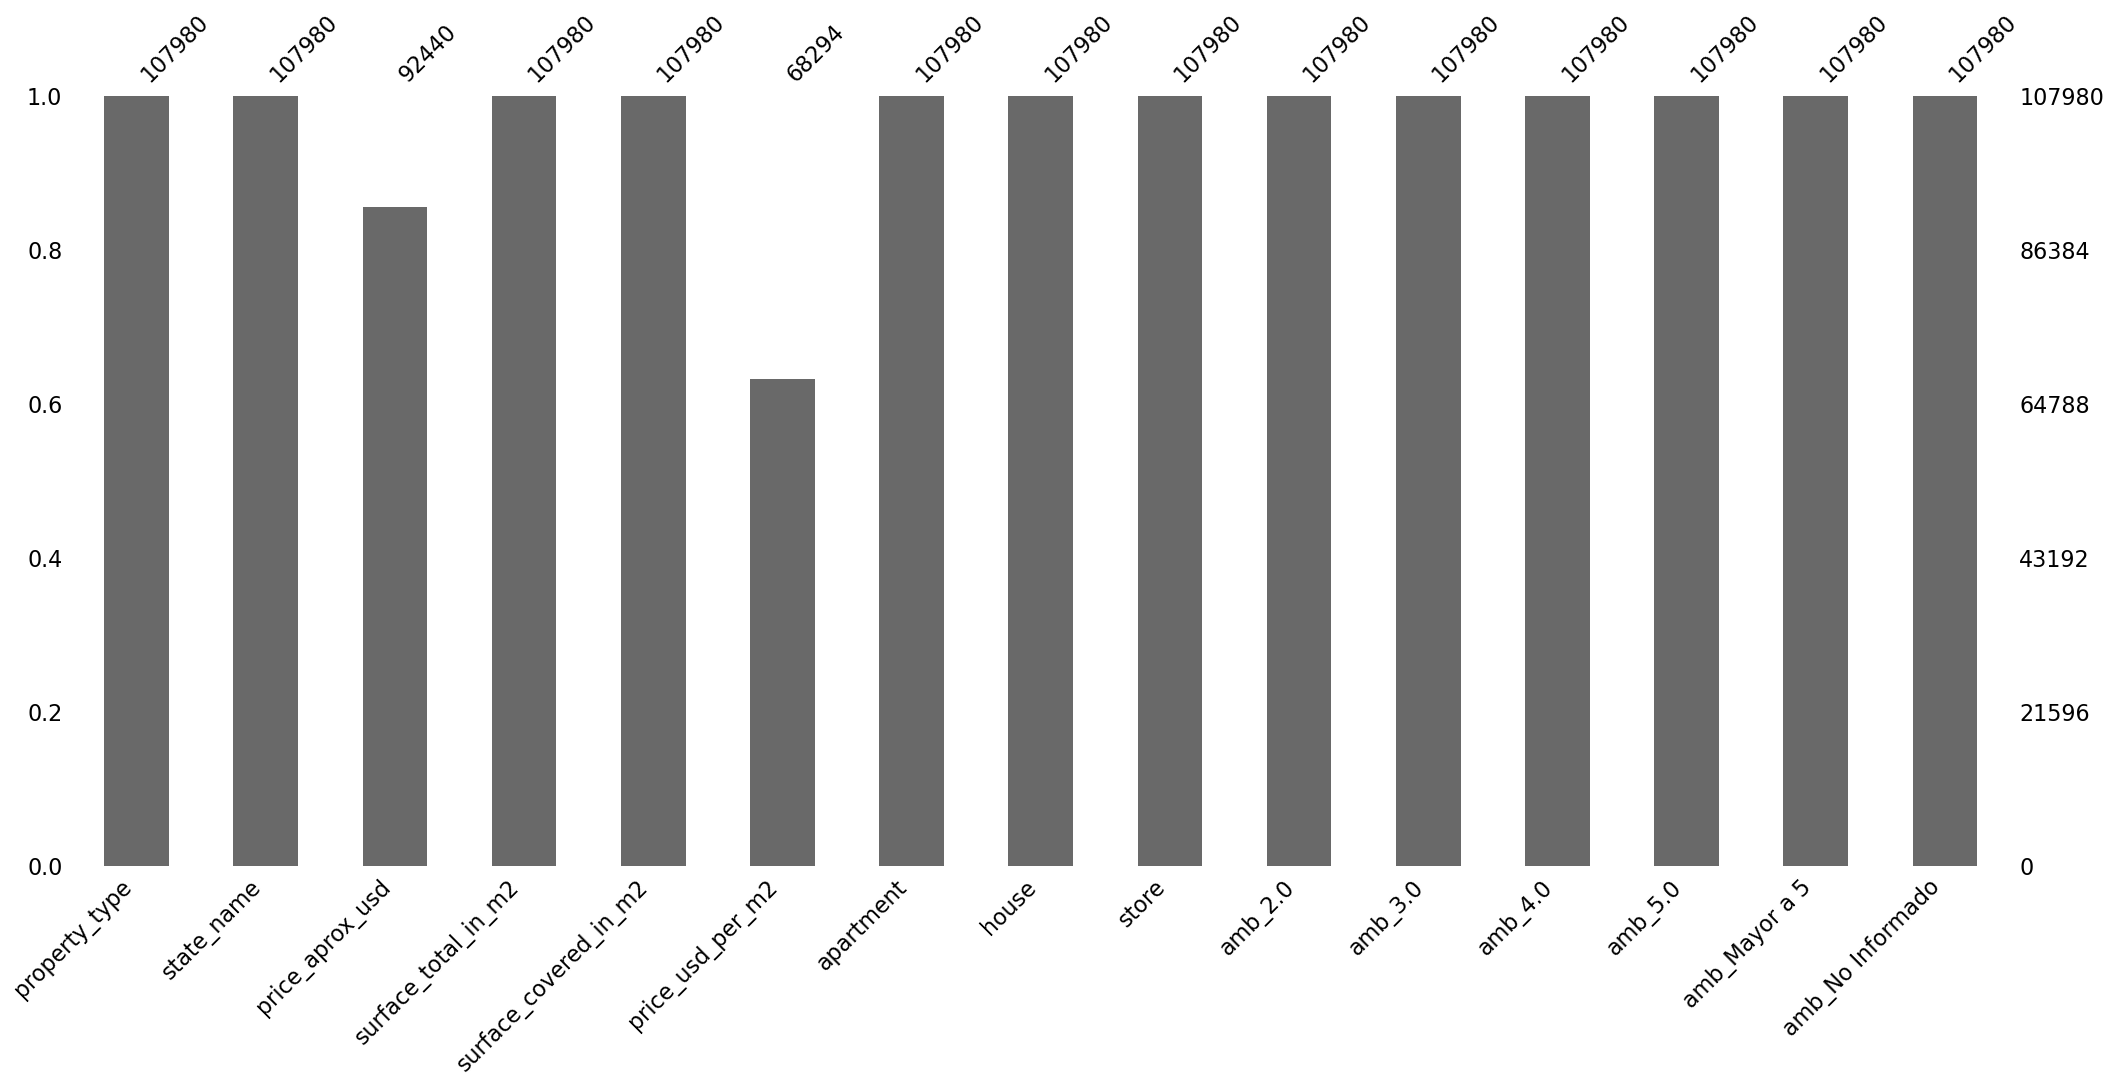

In [18]:
# Para saber valores no nulos

msno.bar(data)

MENCIONAR VARIABILIDAD DE LOS DATOS (HAY QUE COMPLETARLO)

Aproximadamente el 40% de las columnas contienen datos diferentes de NaN dentro de su estructura en el DataFrame. El restante 60% está distribuido de la siguiente manera: 
 - Columnas que contienen entre 50% y 80% de datos completos. (50%)
 - Columnas que contienen por debajo del 40% de datos completos. (10%)

TOMAR DECISIÓN RESPECTO A ¿CUÁL SERÁ NUESTRA VARIABLE TARGET? 

Según el análisis que hicimos para TP1 , propongo tomar como variable target la columna PRICE, QUE TENDRÍAMOS QUE RECUPERAR DEL DATAFRAME PRINCIPAL DE PROPERATTI O EN TAL CASO TOMAR LA COLUMNA PRICE_APROX_USD

## 4. Eliminación de datos.

Eliminar columna que tiene relación con precios y no son nuestra variable target, o ya fueron convertidas en variables dummies 

In [19]:
data.drop(['price_usd_per_m2', 'property_type'], axis = 1, inplace = True)

Eliminar columnas donde existan valores nulos para la variable a predecir (price_aprox_usd)

In [22]:
data.dropna(axis = 0, subset = 'price_aprox_usd', inplace = True)

<AxesSubplot: >

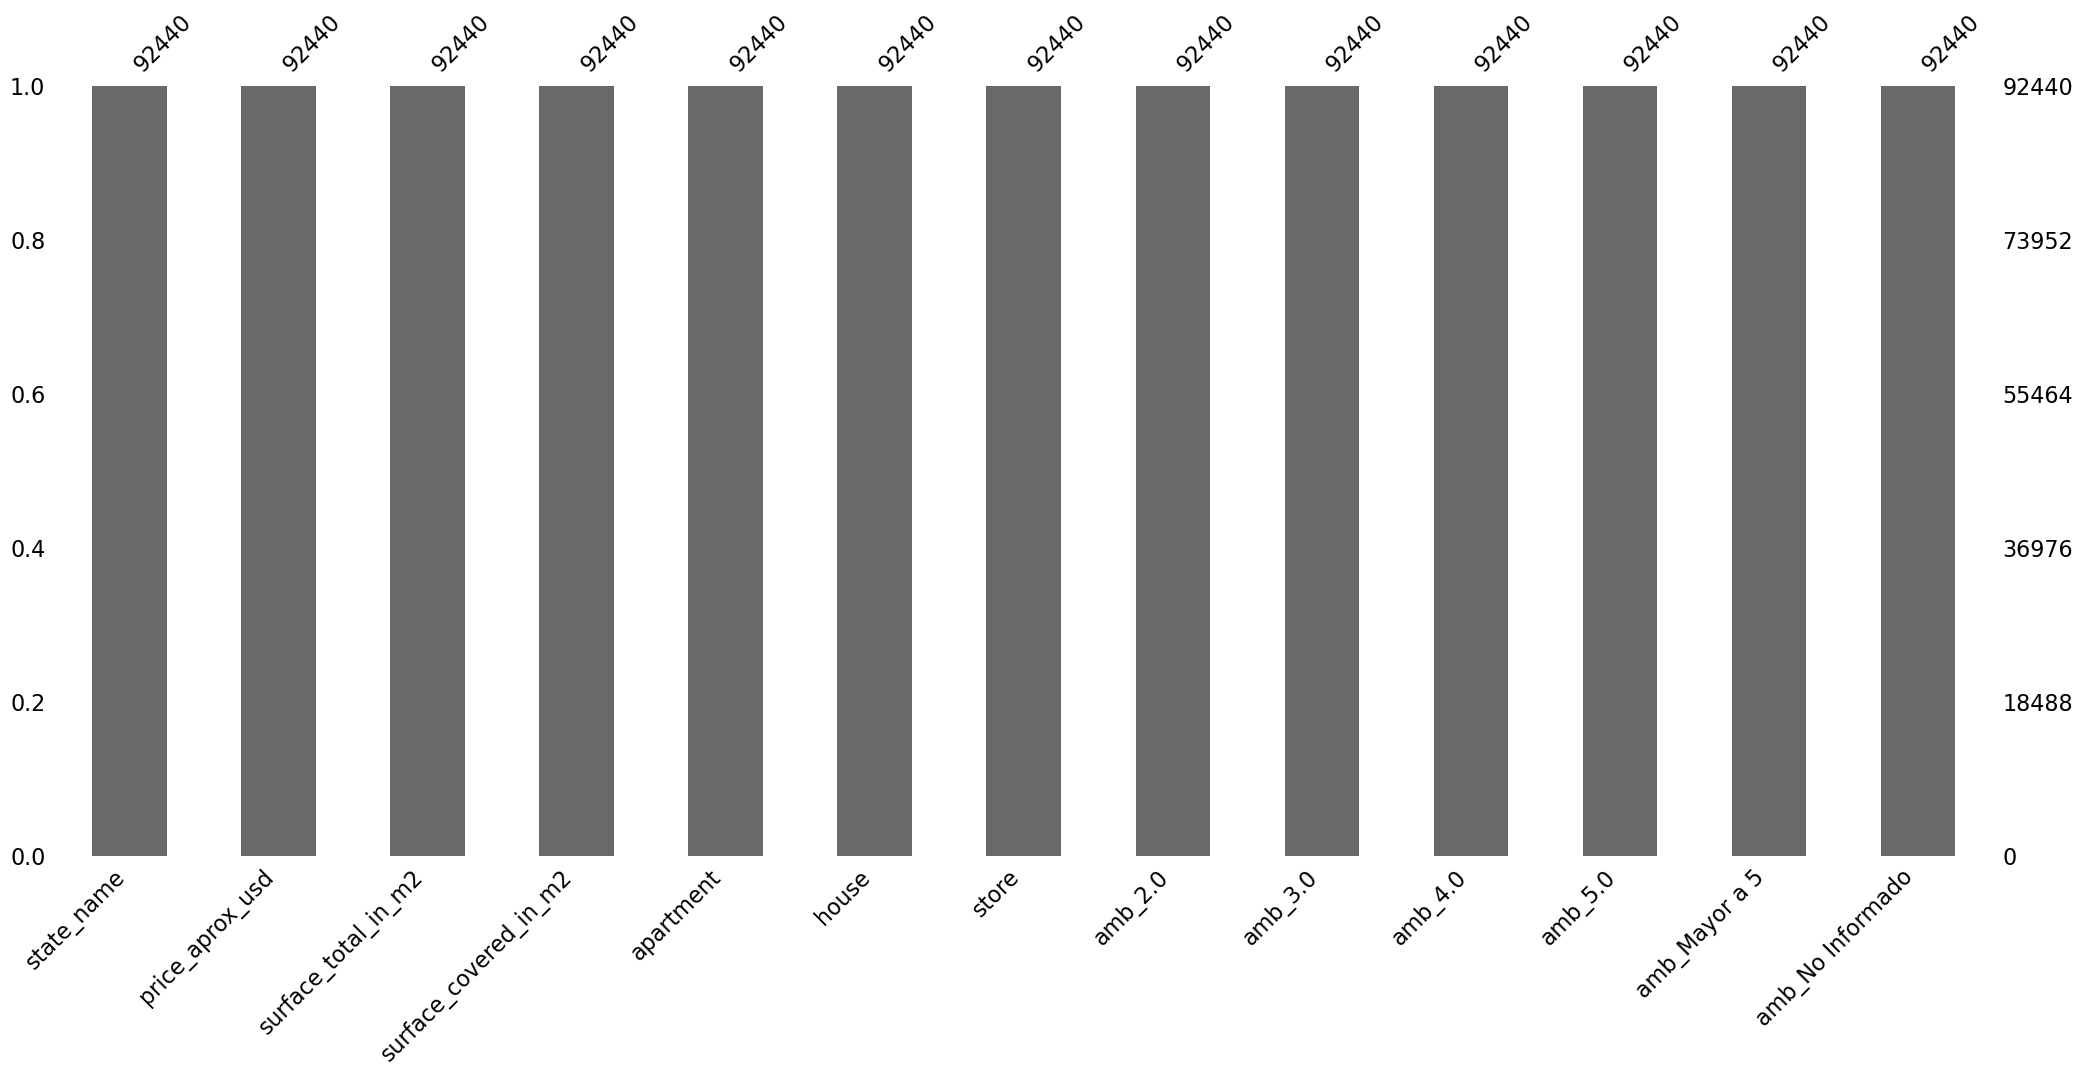

In [23]:
msno.bar(data)

In [25]:
data.sample(3)

,state_name,price_aprox_usd,surface_total_in_m2,surface_covered_in_m2,apartment,house,store,amb_2.0,amb_3.0,amb_4.0,amb_5.0,amb_Mayor a 5,amb_No Informado
102342,Santa Fe,70104.59,37.00000,37.0,0,0,1,0,0,0,0,0,1
102737,Córdoba,171158.40,108.00000,108.0,1,0,0,0,0,0,0,0,1
63459,Capital Federal,138000.00,119.48937,68.0,1,0,0,0,0,0,1,0,0


## 5. Creación de Variables Dummies.

Continuando con el análisis, la propuesta ahora es generar variables dummy para aquellas variables categóricas que podrían aportar información valiosa al momento de clasificar las propiedades.

In [27]:
(data.groupby(['state_name'])['state_name'].count()).sort_values(ascending=False)

state_name
Capital Federal                 28234
Bs.As. G.B.A. Zona Norte        23149
Bs.As. G.B.A. Zona Sur          10453
Buenos Aires Costa Atlántica     7997
Córdoba                          6857
Bs.As. G.B.A. Zona Oeste         6533
Santa Fe                         5055
Buenos Aires Interior            1543
Mendoza                           447
Corrientes                        441
Río Negro                         329
Neuquén                           300
Misiones                          262
Tucumán                           181
San Luis                          169
Chubut                            141
Entre Ríos                        100
Salta                              88
Chaco                              32
Formosa                            29
Tierra Del Fuego                   28
Catamarca                          22
La Pampa                           19
Santa Cruz                         12
Jujuy                              10
San Juan                            4
S